# 1.MORO OPTIMIZATION

# 1.1 Generate random policies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools

In [2]:
from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers

In [3]:
years = 200                     # Current preferred timeframe
A3_deaths_per_year = 0.001      # Translates roughly 1 in 100:000 yearly chance of dike breakage in A.3 ring
other_deaths_per_year = 0.025   # Translates roughly 1 in  10:000 yearly chance of dike breakage in other dike rings
max_A3_total_costs = 170000000  # Our max preferred costs
max_rfr_costs = 1950000000      # Rijkswaterstaat budget of 2.3 billion minus 350 million for our compensation
max_evacuation_costs = 1000000  # No real reason

In [4]:
def robustness(smaller, threshold, data):
    if smaller:
        return np.sum(data <= threshold) / data.shape[0]
    else:
        return np.sum(data >= threshold) / data.shape[0]

A3_number_of_deaths = functools.partial(robustness, True, A3_deaths_per_year*years)
A3_total_costs = functools.partial(robustness, True, max_A3_total_costs)
RfR_total_costs = functools.partial(robustness, True, max_rfr_costs)

In [5]:
from problem_formulation import get_model_for_problem_formulation

model, _ = get_model_for_problem_formulation(3)

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [7]:
use_pickle1 = True
if use_pickle1:
    with open('data/moro_rob_results1.pickle', 'rb') as filehandler:
        results1 = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
        results1 = evaluator.perform_experiments(scenarios=200,
                                                policies=4,
                                                uncertainty_sampling=Samplers.LHS)  # TODO: Consider other samplers
        # Save results in Pickle file
        with open("data/moro_rob_results1.pickle","wb") as filehandler:
            pickle.dump(results1, filehandler)

In [8]:
model.outcomes.keys()

odict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])

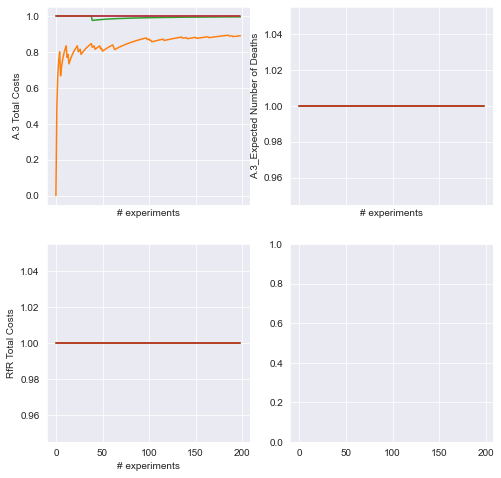

In [9]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

robustness_funcs = {'A.3 Total Costs': A3_total_costs,
                    'A.3_Expected Number of Deaths': A3_number_of_deaths,
                    'RfR Total Costs': RfR_total_costs}

experiments, outcomes = results1

plot_outcomes = {o:v for o,v in outcomes.items() if o in robustness_funcs.keys()}

for ax, (outcome, value) in zip(axes, plot_outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]

        robustness = []

        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

# 1.2 Search for candidate solutions

the fundamental problem is fine tuning the robustness functions. To do this, rather than run optimizaitons many times, why not first generate a test set with a bunch of policies, apply robustness functions and visualize the results?

This gives us much faster feedback on reasonble cutoff values. 


In [10]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 10
n_policies = 25     # Original value: 100 policies

scenarios = sample_uncertainties(model, n_scenarios)

nfe = int(100)      # Original value: 1000

In [11]:
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)

In [12]:
use_pickle2 = True
if use_pickle2:
    with open('data/moro_rob_results2.pickle', 'rb') as filehandler:
        results2 = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
        results2 = evaluator.perform_experiments(scenarios=n_scenarios,
                                                policies=n_policies)
        # Save results in Pickle file
        with open("data/moro_rob_results2.pickle","wb") as filehandler:
            pickle.dump(results2, filehandler)

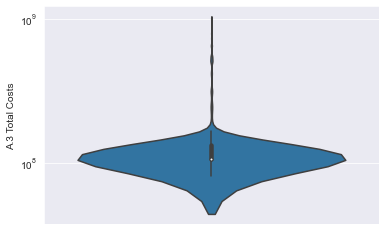

In [13]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='A.3 Total Costs')
ax.set_yscale('log')
plt.show()

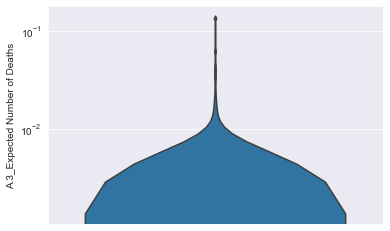

In [14]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='A.3_Expected Number of Deaths')
ax.set_yscale('log')
plt.show()

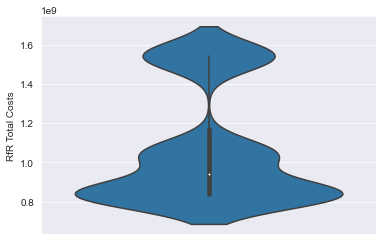

In [15]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='RfR Total Costs')
#ax.set_yscale('log')
plt.show()

## Notebook updated up to here
 - Used problem formulation 3
 - Added constants
 - Rewrote the robustness function
 - Updated pickles and plots

TODO:
 - Try new values for robustness functions below
 - Perform following techniques to determine robustness

In [14]:
Expected_Number_of_Deaths = functools.partial(robustness, True, 1e-5) #not ok
Expected_Annual_Damage = functools.partial(robustness, True, 1e4) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Total_Investment_Costs = functools.partial(robustness, True, 6e8)#THOSE NUMBERS NEED TO BE SPECIFIED AGAIN

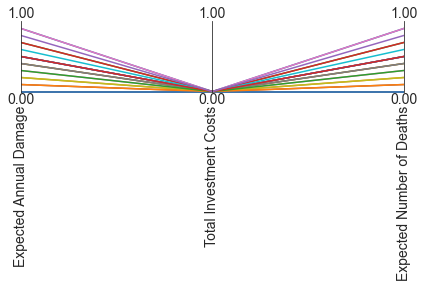

In [15]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results2

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [16]:
from ema_workbench.em_framework.optimization import EpsilonProgress

convergence = [EpsilonProgress()]

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE,
                                     function=Expected_Number_of_Deaths),
                       ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE,
                                     function=Expected_Annual_Damage),
                       ScalarOutcome('Total Investment Costs', kind=MAXIMIZE,
                                     function=Total_Investment_Costs),
                      ]

epsilons=[0.05,]*len(funcs)  #final value of epsilon should be much lower.Just for experiment purposes is 1

use_pickle3 = True
if use_pickle3:
    with open('data/moro_rob_results3.pickle', 'rb') as filehandler:
        results3 = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model) as evaluator:
        results3 = evaluator.robust_optimize(robustnes_functions, scenarios,nfe=nfe, convergence=convergence, epsilons=epsilons)
        # Save results in Pickle file
        with open("data/moro_rob_results3.pickle","wb") as filehandler:
            pickle.dump(results3, filehandler)
archive, convergence = results3

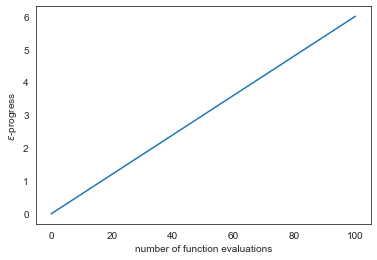

In [17]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [18]:
archive

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Number of Deaths,Expected Annual Damage,Total Investment Costs
0,1,1,0,0,0,0,0,0,1,0,...,6,8,4,0,8,7,3,1.0,1.0,0.0


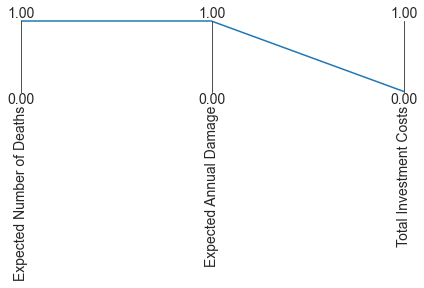

In [19]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

This is a bit better but not much. 

Now, observe the following: you are using a domain criterion as your sole measure of robustness. That is, you look at the fraction of scenarios above or below a threshold. The costs however do not vary accross scenarios. Thus this objective can only be 0 or 1. This is not particularly useful for optimization. 

We might thus want to consider another metric for costs. Why not simply use the raw costs itself?


In [20]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def costs(data):
    return data[0]/1e9 # makes numbers nicer
    
SMALLER = 'SMALLER'

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-5) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1e4) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Total_Investment_Costs = costs

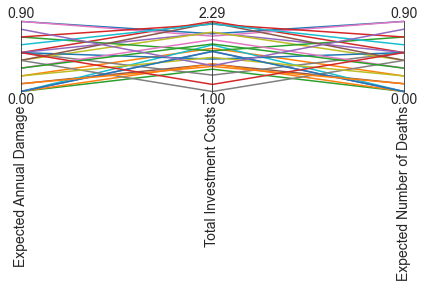

In [21]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results2

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy

    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}

    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

This already looks much nicer.

In [22]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('fraction EA deaths', kind=MAXIMIZE,
                             variable_name='Expected Number of Deaths', function=Expected_Number_of_Deaths),
                       ScalarOutcome('fraction EA damage', kind=MAXIMIZE,
                             variable_name='Expected Annual Damage', function=Expected_Annual_Damage),
                       ScalarOutcome('investment costs', kind=MINIMIZE, # note that we have to minimize costs!
                             variable_name='Total Investment Costs', function=Total_Investment_Costs)]

In [23]:
use_pickle4 = True
if use_pickle4:
    with open('data/moro_rob_results4.pickle', 'rb') as filehandler:
        results4 = pickle.load(filehandler)
else:
    # we have to change the plausible max for total investment costs
    convergence = [EpsilonProgress()]

    epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
    with MultiprocessingEvaluator(model) as evaluator:
        results4 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                         convergence=convergence, epsilons=epsilons)
    # Save results in Pickle file
    with open("data/moro_rob_results4.pickle","wb") as filehandler:
        pickle.dump(results4, filehandler)
archive, convergence = results4

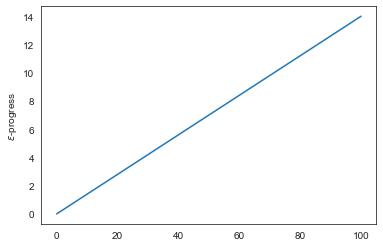

In [24]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

plt.show()

## Note: Jan Kwakkel updated the notebook up to here.
See https://github.com/quaquel/epa1361_open/issues/7#issuecomment-1143904717

AttributeError: 'DataFrame' object has no attribute 'hypervolume'

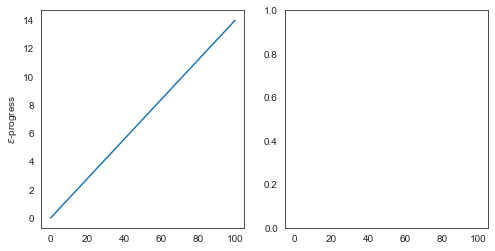

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

# 1.3 Re-evaluate candidate solutions under uncertainty

In [ ]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [ ]:
use_pickle5 = True
if use_pickle5:
    with open('data/moro_rob_results5.pickle', 'rb') as filehandler:
        results5 = pickle.load(filehandler)
else:
    n_scenarios = 100  # Original value: 1000
    with MultiprocessingEvaluator(model) as evaluator:
        results5 = evaluator.perform_experiments(n_scenarios,
                                                policies_to_evaluate)
        # Save results in Pickle file
        with open("data/moro_rob_results5.pickle","wb") as filehandler:
            pickle.dump(results5, filehandler)
#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')

In [ ]:
from ema_workbench import save_results

save_results(results5, 'data/MORO_reevaluation.tar.gz')

In [ ]:
policies.to_csv('data/MORO_polices.csv')

In [ ]:
import pandas as pd
experiments, outcomes = results5

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

In [ ]:
data = overall_robustness.loc[:, ['Expected Number of Deaths', 'Expected Annual Damage', 'Total Investment Costs']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()